# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder

import datetime
import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
df.head()

(163426, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,goal,country,currency,campaign_length,deadline,launched,created,spotlight,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1725323227,1725323227,Inspire young girls,failed,fashion,Childrenswear,1,0.0,30.0,1300.0,US,USD,30,2018-01-12,2017-12-13,2017-12-08,0,0,Rayna,6
2065169465,2065169465,Cotton-Top Pastries,successful,food,Small Batch,99,1.3,9858.0,7500.0,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
1516902916,1516902916,Dreaming Creek Brewery,failed,food,Drinks,64,0.3,6139.0,20000.0,US,USD,30,2018-01-12,2017-12-13,2017-08-11,0,0,Mike Bradley,19
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,failed,games,Playing Cards,131,0.3,3387.0,9999.0,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
1361347175,1361347175,New Boutique Funding for the San Antonio Stock...,failed,fashion,Ready-to-wear,0,0.0,0.0,5000.0,US,USD,15,2018-01-12,2017-12-28,2017-12-22,0,0,Darrian Fosty,26


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df.shape

(41894, 19)

In [7]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'goal', 'country',
       'currency', 'campaign_length', 'deadline', 'launched', 'created',
       'spotlight', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object')

In [16]:
df_dummies = pd.get_dummies(df[['state','category_name', 'country']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(41896, 180)
Index(['state_successful', 'category_name_Academic',
       'category_name_Accessories', 'category_name_Action',
       'category_name_Animals', 'category_name_Animation',
       'category_name_Anthologies', 'category_name_Apparel',
       'category_name_Apps', 'category_name_Architecture',
       ...
       'country', 'currency', 'campaign_length', 'deadline', 'launched',
       'created', 'spotlight', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object', length=180)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41896 entries, 18520 to 2147422173
Columns: 180 entries, state_successful to blurb_length
dtypes: float64(3), int64(6), object(10), uint8(161)
memory usage: 12.8+ MB


In [17]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
X = df.drop(['state_successful','id', 'name', 'state', 'category_main','category_name', 'backers_count','pct_goal_achieved', 'usd_pledged', 'goal', 'country', 'currency',
       'deadline', 'launched', 'created','creator_name','spotlight'], 1)
y = df['state_successful']

print(X.shape)
X.columns
# X.head()

(41896, 163)


Index(['category_name_Academic', 'category_name_Accessories',
       'category_name_Action', 'category_name_Animals',
       'category_name_Animation', 'category_name_Anthologies',
       'category_name_Apparel', 'category_name_Apps',
       'category_name_Architecture', 'category_name_Art Books',
       ...
       'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE',
       'country_SG', 'country_US', 'campaign_length', 'staff_pick',
       'blurb_length'],
      dtype='object', length=163)

## Assumptions

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(29327, 163) (29327,)
(12569, 163) (12569,)


In [19]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
# print(X_train_s.mean(axis=0))
# print(X_train_s.std(axis=0))

# X_combined_s = np.vstack((X_train_s, X_test_s))
# y_combined = np.hstack((y_train, y_test))

## Phase 1: Initial Check on All Models

In [20]:
# Define models to test
model_list = [['GaussianNB', GaussianNB()], 
                ['BernoulliNB', BernoulliNB()], # F1 0.60
                ['MultinomialNB', MultinomialNB()], 
                ['DecisionTree', DecisionTreeClassifier()], 
                ['RandomForest', RandomForestClassifier()], # F1 0.61
                ['KNN', KNeighborsClassifier(38)], # best k from KNN model below; scale data
                ['GradientBoost', GradientBoostingClassifier()],
                ['AdaBoost', AdaBoostClassifier()],
                ['LogisticRegression', LogisticRegression()]]
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data; F1 0.62
#                 ['SVM', SVC(probability=True)]] # scale data; F1 0.57

model_list_s = [['KNN', KNeighborsClassifier(38)], # best k from KNN model below; scale data
                ['LogisticRegression', LogisticRegression()]] # scale data
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data
#                 ['SVM', SVC(probability=True)]] # scale data

# Calculate metrics for each model
roc = {}
for model in model_list:
    if model in model_list_s:
        X_train = X_train_s
        X_test = X_test_s
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
    error_rate = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        error_rate.append(np.mean(y_pred != y_test))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score)
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))  

GaussianNB(priors=None)
	Accuracy: 0.6515235897843902
	AUC: 0.6534729873249363


[[6180   68]
 [4312 2009]]
             precision    recall  f1-score   support

          0       0.59      0.99      0.74      6248
          1       0.97      0.32      0.48      6321

avg / total       0.78      0.65      0.61     12569

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.743416341793301
	AUC: 0.7440449224087098


[[5325  923]
 [2302 4019]]
             precision    recall  f1-score   support

          0       0.70      0.85      0.77      6248
          1       0.81      0.64      0.71      6321

avg / total       0.76      0.74      0.74     12569

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
	Accuracy: 0.7396769830535445
	AUC: 0.7400304879716232


[[5004 1244]
 [2028 4293]]
             precision    recall  f1-score   support

          0       0.71      0.80      0.75      6248
          1       0.78      0.68      0.72      6321

avg 

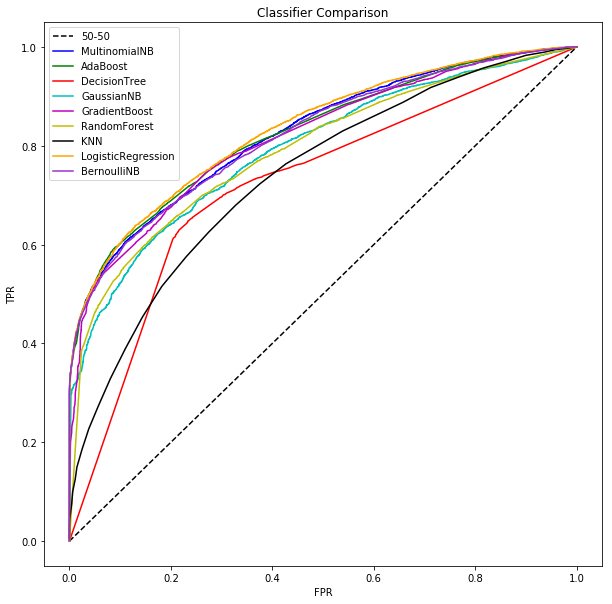

In [21]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange','darkorchid','bisque']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, c in zip(roc.keys(), colors):
    ax.plot(roc[key][0], roc[key][1], color=c, label=key)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Classifier Comparison')
ax.legend(loc='best')
plt.savefig('charts/roc_ds2_p1.png')